In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
from datetime import datetime, timedelta

In [2]:
tsp_on__routeName_direction_to_delayed_frames = pd.read_pickle("tsp_on__routeName_direction_to_delayed_frames.pkl")
tsp_off__routeName_direction_to_delayed_frames = pd.read_pickle("tsp_off__routeName_direction_to_delayed_frames.pkl")

In [3]:
# for every routeName direction find list of intersections that were ever crossed at this route.
# if they didn't occur among delayed point in given trip, we consider that for this intersection in this thip delay is 0
routeName_direction_to_list_of_intersections = defaultdict(list)

for k, val in tsp_on__routeName_direction_to_delayed_frames.items():
    cur_inters = []
    for x in val:
        cur_inters.append(x['upcoming_intersection_loc_id'])
        
    routeName_direction_to_list_of_intersections[k] += list(set(cur_inters))

for k, val in tsp_off__routeName_direction_to_delayed_frames.items():
    cur_inters = []
    for x in val:
        cur_inters.append(x['upcoming_intersection_loc_id'])
        
    routeName_direction_to_list_of_intersections[k] += list(set(cur_inters))
    
for k in routeName_direction_to_list_of_intersections.keys():
    routeName_direction_to_list_of_intersections[k] = set(routeName_direction_to_list_of_intersections[k])
    

In [4]:
tsp_on__routeName_direction_to_uid_to_delayed_frames = defaultdict(defaultdict)
tsp_off__routeName_direction_to_uid_to_delayed_frames = defaultdict(defaultdict)


for k in tsp_on__routeName_direction_to_delayed_frames:
    for p in tsp_on__routeName_direction_to_delayed_frames[k]:
        if tsp_on__routeName_direction_to_uid_to_delayed_frames[k].get(p['logID'] + "_" + p['deviceID']):
            tsp_on__routeName_direction_to_uid_to_delayed_frames[k][p['logID'] + "_" + p['deviceID']].append(p)
        else:
            tsp_on__routeName_direction_to_uid_to_delayed_frames[k][p['logID'] + "_" + p['deviceID']] = []
            tsp_on__routeName_direction_to_uid_to_delayed_frames[k][p['logID'] + "_" + p['deviceID']].append(p)
    
    for uid in tsp_on__routeName_direction_to_uid_to_delayed_frames[k].keys():
        found_intersections = [x['upcoming_intersection_loc_id'] for x in tsp_on__routeName_direction_to_uid_to_delayed_frames[k][uid]]
        not_found_intersections = set(routeName_direction_to_list_of_intersections[k]) - set(found_intersections)
        
        for inter in not_found_intersections:
            res = {'upcoming_intersection_loc_id': inter,
  'logID': uid.split("_")[0],
  'deviceID': uid.split("_")[1],
  'time_delay': timedelta(seconds=0)}
            tsp_on__routeName_direction_to_uid_to_delayed_frames[k][uid].append(res)
            
            
for k in tsp_off__routeName_direction_to_delayed_frames:
    for p in tsp_off__routeName_direction_to_delayed_frames[k]:
        if tsp_off__routeName_direction_to_uid_to_delayed_frames[k].get(p['logID'] + "_" + p['deviceID']):
            tsp_off__routeName_direction_to_uid_to_delayed_frames[k][p['logID'] + "_" + p['deviceID']].append(p)
        else:
            tsp_off__routeName_direction_to_uid_to_delayed_frames[k][p['logID'] + "_" + p['deviceID']] = []
            tsp_off__routeName_direction_to_uid_to_delayed_frames[k][p['logID'] + "_" + p['deviceID']].append(p)
    
    for uid in tsp_off__routeName_direction_to_uid_to_delayed_frames[k].keys():
        found_intersections = [x['upcoming_intersection_loc_id'] for x in tsp_off__routeName_direction_to_uid_to_delayed_frames[k][uid]]
        not_found_intersections = set(routeName_direction_to_list_of_intersections[k]) - set(found_intersections)
        
        for inter in not_found_intersections:
            res = {'upcoming_intersection_loc_id': inter,
  'logID': uid.split("_")[0],
  'deviceID': uid.split("_")[1],
  'time_delay': timedelta(seconds=0)}
            tsp_off__routeName_direction_to_uid_to_delayed_frames[k][uid].append(res)
        
            

In [5]:
tsp_on__routeName_direction_intersection_loc_id_to_total_time_delays = defaultdict(list)
tsp_off__routeName_direction_intersection_loc_id_to_total_time_delays = defaultdict(list)

for route_dir in tsp_on__routeName_direction_to_uid_to_delayed_frames.keys():
    for uid in tsp_on__routeName_direction_to_uid_to_delayed_frames[route_dir].keys():
        cur_delays = tsp_on__routeName_direction_to_uid_to_delayed_frames[route_dir][uid]
        
        cur_intersection_to_total_delay = defaultdict(timedelta)
        for delay in cur_delays:
            cur_intersection_to_total_delay[delay['upcoming_intersection_loc_id']] += delay['time_delay']
            
        for intersec_id in cur_intersection_to_total_delay.keys():
            tsp_on__routeName_direction_intersection_loc_id_to_total_time_delays[route_dir + "_" + intersec_id].append(cur_intersection_to_total_delay[intersec_id].total_seconds())
            
        
for route_dir in tsp_off__routeName_direction_to_uid_to_delayed_frames.keys():
    for uid in tsp_off__routeName_direction_to_uid_to_delayed_frames[route_dir].keys():
        cur_delays = tsp_off__routeName_direction_to_uid_to_delayed_frames[route_dir][uid]
        
        cur_intersection_to_total_delay = defaultdict(timedelta)
        for delay in cur_delays:
            cur_intersection_to_total_delay[delay['upcoming_intersection_loc_id']] += delay['time_delay']
            
        for intersec_id in cur_intersection_to_total_delay.keys():
            tsp_off__routeName_direction_intersection_loc_id_to_total_time_delays[route_dir + "_" + intersec_id].append(cur_intersection_to_total_delay[intersec_id].total_seconds())
   

In [6]:
from scipy import stats
# mann-whitney u-test
def mannwhitney(triplogs_on, triplogs_off):
    rejected = []
    num_errors = 0
    for k_on in triplogs_on.keys():
        if k_on in triplogs_off.keys():
            try:
                pval = stats.mannwhitneyu(triplogs_on[k_on], triplogs_off[k_on], alternative='less').pvalue
                if pval < 0.05:
                    pass
                    #print(idx, f'route is significally faster with pval {pval:.2f}')
                rejected.append(
                    (pval, k_on)
                )
            except ValueError:
                num_errors += 1
            
    print(len(rejected), 'of', len(triplogs_on), 'rejected', len(rejected)/len(triplogs_on))
    return rejected, num_errors

In [7]:
# student two samples t-test
def student(triplogs_on, triplogs_off):
    rejected = []
    num_errors = 0
    for k_on in triplogs_on.keys():
        if k_on in triplogs_off.keys():   
            pval = stats.ttest_ind(triplogs_on[k_on], triplogs_off[k_on], alternative='less').pvalue
            if pval < 0.05:
                # check same variance assumption (timings of two type of routes must have variance close to each other)
                s1 = np.sqrt(np.var(triplogs_on[k_on], ddof=1))
                s2 = np.sqrt(np.var(triplogs_off[k_on], ddof=1))
                valid = 'test valid'
                if np.abs(s1 - s2) > 3:
                    num_errors += 1
                else:
                    rejected.append(
                        (pval, k_on)
                    )
    print(len(rejected), 'of', len(triplogs_on), 'rejected', len(rejected)/len(triplogs_on))
    return rejected, num_errors

In [8]:
def plot_trips(triplogs_on, triplogs_off, rejected_idxs):
    fig, ax = plt.subplots(len(rejected_idxs), 1,figsize=(15,15), constrained_layout=True)
    for i, (pval, idx)  in enumerate(rejected_idxs):
        title = str(idx) +", " + "pval: " + str(round(pval, 2))
        ax[i].set_title(title)
        ax[i].plot(triplogs_on[idx], label='on')
        ax[i].plot(triplogs_off[idx], label='off')
        ax[i].legend()

In [9]:
tsp_on_dict = tsp_on__routeName_direction_intersection_loc_id_to_total_time_delays
tsp_off_dict = tsp_off__routeName_direction_intersection_loc_id_to_total_time_delays

1230 of 1377 rejected 0.8932461873638344
number of errors: 29


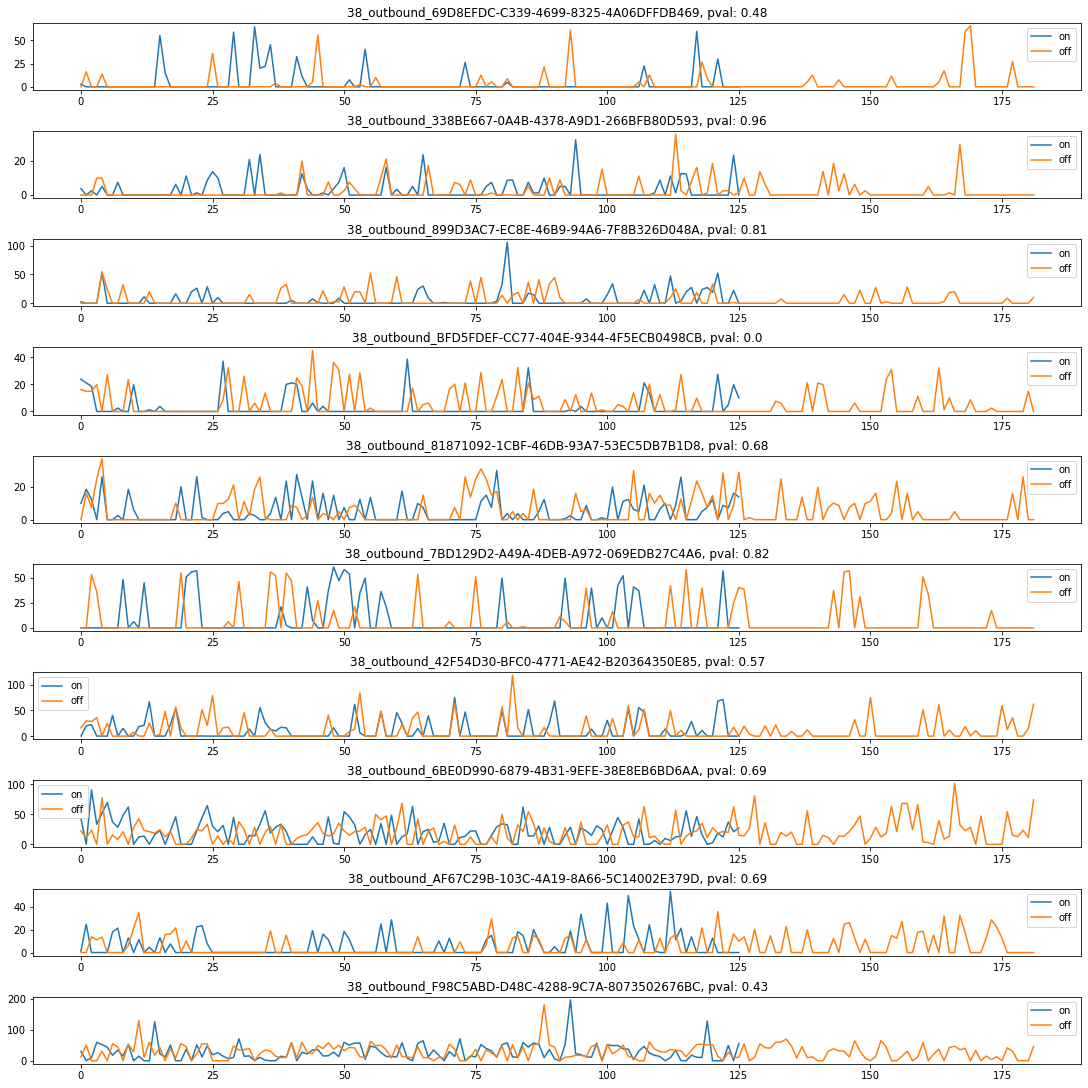

In [10]:
import matplotlib.pyplot as plt
rejected_idxs_manw, num_errs = mannwhitney(tsp_on_dict, tsp_off_dict)
print("number of errors:", num_errs)
plot_trips(tsp_on_dict, tsp_off_dict, rejected_idxs_manw[:10])

/Users/mkmet/opt/anaconda3/envs/gtt_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/mkmet/opt/anaconda3/envs/gtt_env/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


19 of 1377 rejected 0.013798111837327523
number of errors: 37


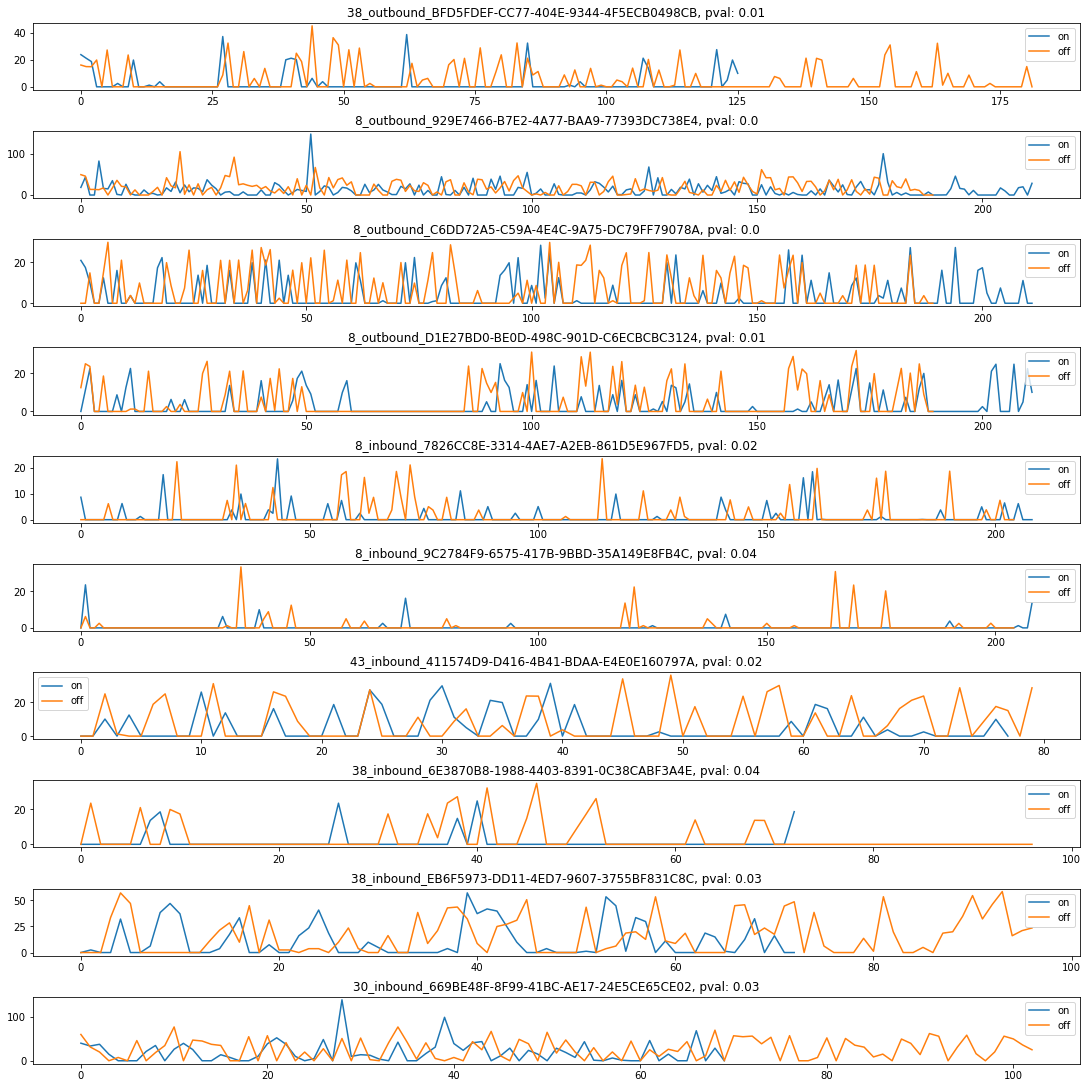

In [11]:
import matplotlib.pyplot as plt
rejected_idxs_student, num_errs = student(tsp_on_dict, tsp_off_dict)
print("number of errors:", num_errs)
plot_trips(tsp_on_dict, tsp_off_dict, rejected_idxs_student[:10])

## Hourly separation

In [12]:
import os
import data_preparation_faster
from data_preparation_faster import prepare_triplogs, prepare_tripdatas, get_clean_triplogs, get_clean_tripdatas

In [13]:
data_dir = "../2020_11_8_to_2020_11_14"

triplogs_df = pd.read_csv(os.path.join(data_dir, "CVP/triplogs.csv"))

triplogs_df = prepare_triplogs(triplogs_df)

In [14]:
uid_to_starthour = {}
for ind, row in triplogs_df[['starthour', 'logid', 'deviceid']].iterrows():
    uid_to_starthour[row['logid'] + "_" + row['deviceid']] = row['starthour']

In [15]:
# here time (hour) is time of start of current trip (not time when the bus crosses the intersection or when the delay occurs)
tsp_on__routeName_direction_intersection_loc_id_hour_to_total_time_delays = defaultdict(list)
tsp_off__routeName_direction_intersection_loc_id_hour_to_total_time_delays = defaultdict(list)

for route_dir in tsp_on__routeName_direction_to_uid_to_delayed_frames.keys():
    for uid in tsp_on__routeName_direction_to_uid_to_delayed_frames[route_dir].keys():
        cur_delays = tsp_on__routeName_direction_to_uid_to_delayed_frames[route_dir][uid]
        
        cur_intersection_to_total_delay = defaultdict(timedelta)
        for delay in cur_delays:
            cur_intersection_to_total_delay[delay['upcoming_intersection_loc_id']] += delay['time_delay']
            
        for intersec_id in cur_intersection_to_total_delay.keys():
            trip_hour = uid_to_starthour[uid]
            total_time_delay = cur_intersection_to_total_delay[intersec_id].total_seconds()
            tsp_on__routeName_direction_intersection_loc_id_hour_to_total_time_delays[route_dir + "_" + intersec_id + "_hour" + str(trip_hour)].append(total_time_delay)
            
        
for route_dir in tsp_off__routeName_direction_to_uid_to_delayed_frames.keys():
    for uid in tsp_off__routeName_direction_to_uid_to_delayed_frames[route_dir].keys():
        cur_delays = tsp_off__routeName_direction_to_uid_to_delayed_frames[route_dir][uid]
        
        cur_intersection_to_total_delay = defaultdict(timedelta)
        for delay in cur_delays:
            cur_intersection_to_total_delay[delay['upcoming_intersection_loc_id']] += delay['time_delay']
            
        for intersec_id in cur_intersection_to_total_delay.keys():
            trip_hour = uid_to_starthour[uid]
            total_time_delay = cur_intersection_to_total_delay[intersec_id].total_seconds()
            tsp_off__routeName_direction_intersection_loc_id_hour_to_total_time_delays[route_dir + "_" + intersec_id + "_hour" + str(trip_hour)].append(total_time_delay)
   

In [16]:
tsp_on_dict = tsp_on__routeName_direction_intersection_loc_id_hour_to_total_time_delays
tsp_off_dict = tsp_off__routeName_direction_intersection_loc_id_hour_to_total_time_delays

7792 of 16602 rejected 0.46934104324780146
number of errors: 5712


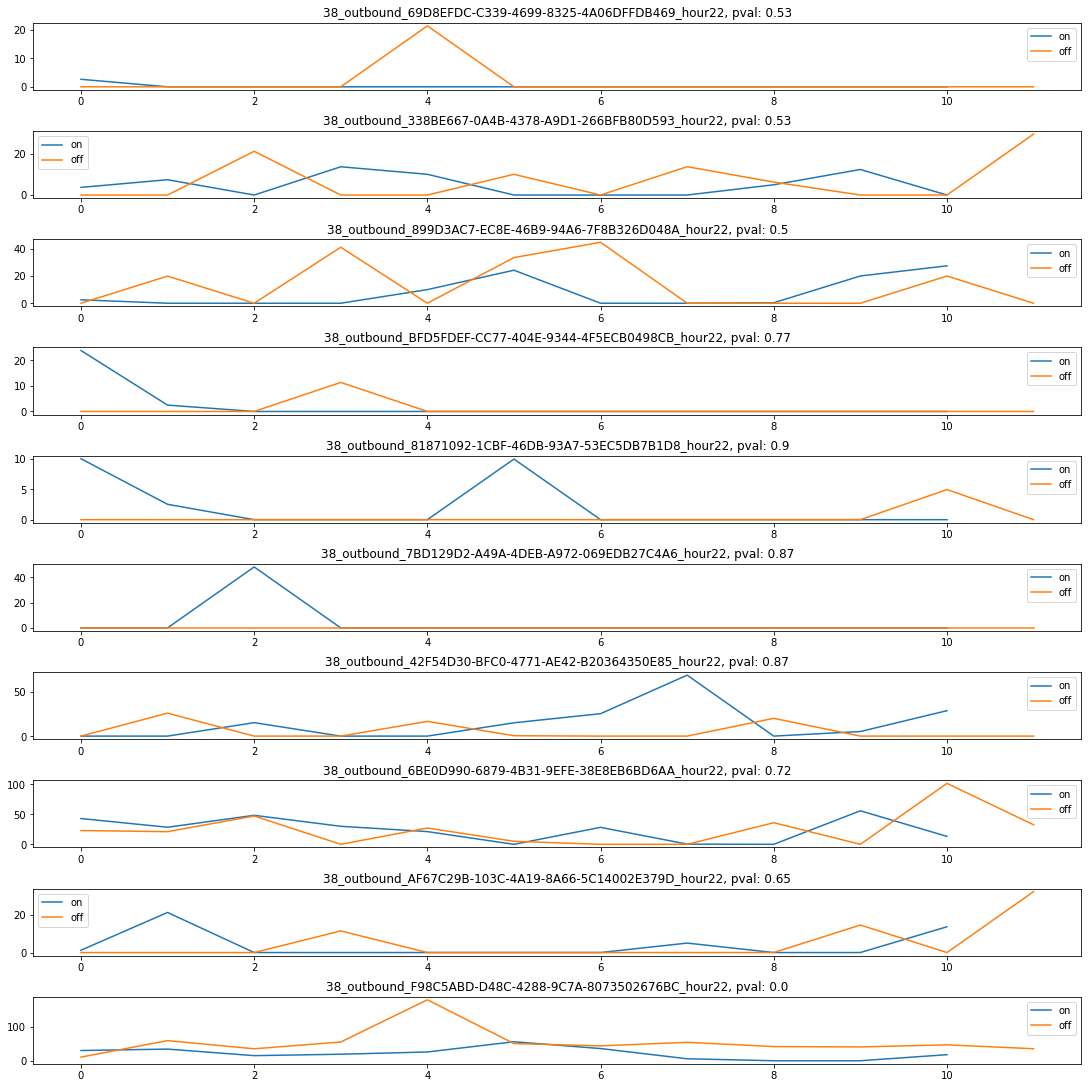

In [17]:
import matplotlib.pyplot as plt
rejected_idxs_manw, num_errs = mannwhitney(tsp_on_dict, tsp_off_dict)
print("number of errors:", num_errs)
plot_trips(tsp_on_dict, tsp_off_dict, rejected_idxs_manw[:10])

49 of 16602 rejected 0.0029514516323334537
number of errors: 164


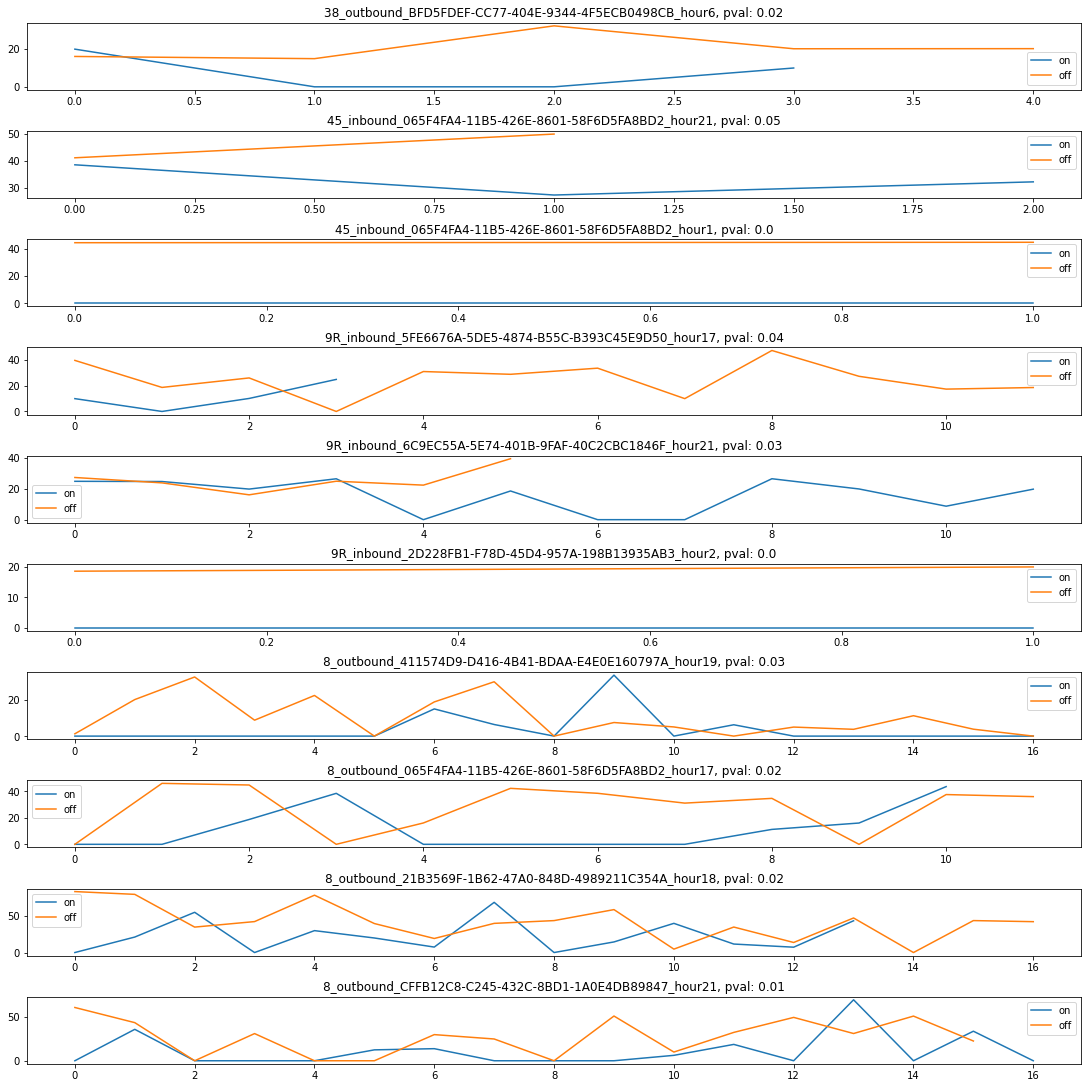

In [18]:
import matplotlib.pyplot as plt
rejected_idxs_student, num_errs = student(tsp_on_dict, tsp_off_dict)
print("number of errors:", num_errs)
plot_trips(tsp_on_dict, tsp_off_dict, rejected_idxs_student[:10])